<center>
<img src="logo.png" height="900"> 
</center>


#  Байесовские методы

В этой тетрадке мы попробуем поработать с библиотекой pymc3.

In [1]:
import numpy as np
import pandas as pd

from scipy import stats 

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
# !pip3 install pymc3

In [4]:
import pymc3 as pm
pm.__version__

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


'3.11.1'

# 1. Петя и караси

Сгенерируем из распределения Бернулли с $p=0.3$ выборку карасей и щук

In [5]:
y = stats.bernoulli(p=0.3).rvs(100)
print('Доля карасей в выборке:', y.mean())
y

Доля карасей в выборке: 0.34


array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

Задаём нашу модель и априорное распределение. 

In [6]:
basic_model = pm.Model()

with basic_model:
    p = pm.Uniform(name="karases_prop", lower=0, upper=1)   # априорное распределение для доли 
    y_obs = pm.Bernoulli(name='y_obs', p = p, observed=y)   # модель

Байесовские методы для бедных: находим оценку моды апостериорного распределения. Её можно использовать в качестве точечной байесовской оценки. Когда мы не можем найти знаменатель в формуле Байеса, единственное, что нам остаётся - посчитать моду. 

In [7]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'karases_prop_interval__': array(-0.66329422), 'karases_prop': array(0.34)}

Но, конечно же, лучше получить апостериорное распределение полностью. Для этого запустим 500 итераций MCMC.

In [8]:
with basic_model:
    trace = pm.sample(500, return_inferencedata=False, model=basic_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [karases_prop]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1504 seconds.


Посмотрим, что у нас получилось. Апостериорное распределенеи параметра лежит в переменной `trace` по ключу с её названием. 

In [9]:
# Последние 5 значений в выборке
trace["karases_prop"][-5:]

array([0.37320054, 0.28865111, 0.33000771, 0.32213777, 0.25662892])

In [10]:
# размер выборки
trace["karases_prop"].shape

(2000,)

С помощью пакета `arviz` можно провалидировать обучение модели и посмотреть на краткое саммари.

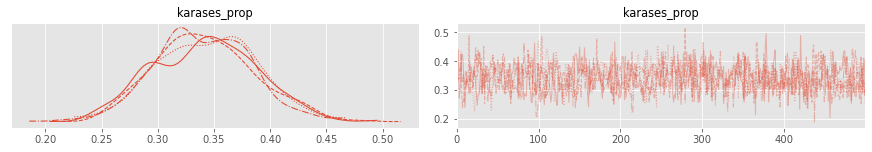

In [11]:
import arviz as az
az.plot_trace(trace);

Алгоритм запустится $4$ раза. Слева будут отрисованы апостериорные распределения (сглаженные и отнормированные гистограммы для апостериорных выборок, полученныех в результате MCMC). Справа будет график истории марковской цепи. Анализируя ее, можно понять, насколько хорошо отработал алгоритм и требует ли он дополнительной настройки. Визуальными критериями качества являются:

- Стационарность. Сэмплы должны образовывать шум вогруг какого-то значения.
- Не имеют сильно выраженной автокорреляции.
- Вся история не может стостоять из одной и той же повторяющейся точки. Если какая-то переменная оставалась константой, то скорее всего что-то пошло не так.

Понятное дело, что итерации, указанные нами в опциях алгоритма для прогрева не входят в итоговую выборку.

In [12]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
karases_prop,0.34,0.05,0.26,0.42,0.0,0.0,878.11,878.11,886.11,1446.61,1.0


Обратите внимание на колонку `r_hat`. Грубо говоря, это отношение дисперсий между цепями к десперсии внутри цепей. Это значение должно быть близко к $1$, иначе разные цепи ведут себя не одинаково и с алгоритмом есть проблемы. 

__Визуализация MCMC:__ https://chi-feng.github.io/mcmc-demo/

# 2. Структурный сдвиг

Проанализируем данные по авариям на шахтах в Англии. Они собираются с 19 века.

In [13]:
df = pd.read_csv('coals.csv', index_col=0)
print(df.shape)
df.head()

(112, 2)


,year,count
1,1851,4
2,1852,5
3,1853,4
4,1854,1
5,1855,0


Посмотрим на то, как число аварий ведёт себя в динамике. Можно заметить, что в 20 веке аварий стало меньше. Судя по всему, работать в шахтах стало безопаснее. Было бы интересно найти момент, когда произошёл структурный сдвиг. 

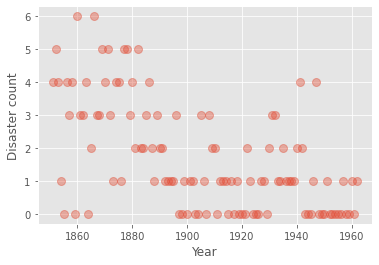

In [14]:
years = df['year'].values
y = df['count'].values

plt.plot(years, y, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year");

Попробуем оценить момент структурного сдвига с помощью Байесовских методов. Число аварий - случайная величина счётчик. Для моделирования счётчиков отлично подходит распределение Пуассона: 

$$
Y_t \sim Poiss(\lambda)
$$

Мы не знаем значения $\lambda$ и предполагаем, что где-то между $19$ и $20$ веками произошёл структурный сдвиг. Работать на шахтах стало безопаснее. Хочется найти наиболее вероятный момент этого сдвига. Специфицируем модель следующим образом:

$$
\lambda = \begin{cases} \lambda_1, \text{ если } t < \tau \\ \lambda_2, \text{ если } t \ge \tau \end{cases}
$$

Если в реальности никакого сдвига нет, то окажется, что $\lambda_1 = \lambda_2$. Апостериорные распределения этих параметров будут выглядеть практически одинаково. Про эти значения мы знаем, что они должны быть положительными. Зададим это знание с помощью априорных распределений:  

$$
\lambda_1 \sim Exp(\alpha), \quad \lambda_2 \sim Exp(\alpha)
$$

Параметр $\alpha$ здесь - это гиперпараметр. Про него мы ничего не знаем. Для него можно также завести своё априорное распределение. Например, нормальное с высокой дисперсией. Либо можно выставить его таким, чтобы для $\lambda_i$ дисперсия оказалась высокой. 

In [15]:
alpha = 0.1
1/alpha**2

99.99999999999999

In [16]:
with pm.Model() as disaster_model:
    
    # априорные распределения для параметров: 
    tau = pm.DiscreteUniform("tau", lower=years.min(), upper=years.max())
    
    early_rate = pm.Exponential("early_rate", alpha)
    late_rate = pm.Exponential("late_rate", alpha)
    
    # разные значения lambda в зависимости от tau
    rate = pm.math.switch(tau >= years, early_rate, late_rate)
    
    # связь y с rate
    y_obs = pm.Poisson("disasters", rate, observed=y)

Запускаем MCMC.

In [ ]:
with disaster_model:
    trace = pm.sample(10000, return_inferencedata=False, model=disaster_model)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [late_rate, early_rate]


Посмотрим что получилось на графиках. 

In [ ]:
az.plot_trace(trace);

In [ ]:
az.summary(trace, round_to=2)

Оценим вероятность того, что $\lambda_1$ отличается от $\lambda_2$:

In [ ]:
np.mean(trace["early_rate"] - trace["late_rate"] > 0)

Можно задаться более сложным вопросом, например: "Какова вероятность, что значения различаются по крайней мере на $1$? На $2$? На $3$? На $5$?

In [ ]:
for d in [1,2,3,5]:
    v = np.mean(np.abs(trace["early_rate"] - trace["late_rate"]) > d)
    print(f'Вероятность того, что значения различаются более, чем на {d} равна {v}')

Найдём наиболее вероятный момент структурного сдвига и нарисуем для него $95\%$ байесовский доверительный интервал. 

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(years, y, ".", alpha=0.6)
plt.ylabel("Число аварий", fontsize=16)
plt.xlabel("Год", fontsize=16)

plt.vlines(
    trace["tau"].mean(), y.min(), y.max(), color="C1"
)

average_disasters = np.zeros_like(y, dtype="float")

for i, year in enumerate(years):
    idx = year < trace["tau"]
    average_disasters[i] = (
        trace["early_rate"][idx].sum() + trace["late_rate"][~idx].sum()
    ) / (len(trace) * trace.nchains)
    
sp_hpd = az.hdi(trace["tau"])

plt.fill_betweenx(
    y=[y.min(), y.max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)

plt.plot(years, average_disasters, "k--", lw=2);

# 3. Регрессия - моя профессия

По аналогии можно оценивать более сложные модели. Например, регрессию. Воспользуемся данными по рекламе и продажам на разных рынках. 

In [ ]:
df = pd.read_csv('Advertising.csv', index_col=0)
print(df.shape)
df.head()

Прологарифмируем продажи и деньги, которые мы вложили на рекламу по тв.

In [ ]:
df['ln_TV'] = df['TV'].apply(np.log)
df['ln_Sales'] = df['Sales'].apply(np.log)

X = df[['ln_TV', 'Radio', 'Newspaper']].values
y = df.ln_Sales.values

Выбирем для коэффициентов априорные распределени. Мы про них знаем не особо много, поэтому будем выбирать высокие дисперсии.  Дисперсия должна быть всегда положительной, поэтому для неё возьмём экспоненциальное распределение с высокой дисперсией. 

\begin{equation*}
\begin{aligned}
& y \sim N(\mu, \sigma^2) \\ 
& \mu = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} \\
& \beta_i \sim N(0, 10^2) \\
& \sigma \sim Exp(0.01) \\
\end{aligned}
\end{equation*}

In [ ]:
regression_model = pm.Model()

with regression_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=100,  shape=3) # ничего не знаем про коэффициенты
    sigma = pm.Exponential("sigma", 0.01) # маленькая alpha => большая дисперсия 1/alpha^2
    
    X = pm.Data("pred", X)
    # Expected value of outcome
    mu = alpha + X@beta

    # Likelihood (sampling distribution) of observations
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

Запускаем обучение. 

In [ ]:
with regression_model:
    trace = pm.sample(5000, return_inferencedata=False, model=regression_model)

In [ ]:
az.plot_trace(trace);

In [ ]:
az.summary(trace, round_to=2)

Найдём вероятность того, что коэффициенты отличаются от нуля. 

In [ ]:
trace['beta'].shape

In [ ]:
np.mean(trace['beta'] > 0, axis=0)

In [ ]:
# не забывайте о то, что мы работаем с выборками из апостериорных распределений
np.mean(trace['beta'] > 1e-2, axis=0)

Посмотрим на байесовские интервалы для наших коэффициентов. 

In [ ]:
pm.forestplot(trace, varnames=['beta'], hdi_prob=0.9999, figsize=(15, 5));

Эту же модель можно использовать для прогнозирования! 

In [ ]:
X_new = np.array([[1.2, 4, 3], [5, 47, 120]])

In [ ]:
with regression_model:
    pm.set_data({"pred": X_new})
    model_preds = pm.sample_posterior_predictive(trace, var_names=["y_obs"])["y_obs"]

In [ ]:
model_preds.shape

In [ ]:
sns.distplot(model_preds[:,0]);

In [ ]:
sns.distplot(model_preds[:,1]);

# Материалы:

- [Ещё модели](https://docs.pymc.io/nb_examples/index.html)
- [Отличная простая книга про вероятностное программирование на python на pymc3](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)
- [Введение в MCMC](https://twiecki.io/blog/2015/11/10/mcmc-sampling/)
- Ещё одна хорошая книга [Statistical rethinking](http://xcelab.net/rm/statistical-rethinking/) с примерами в R и pymc3